In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):  # Lists all image files
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


# 1. Importing the necessary libraries

Keep the Internet in `ON` mode.

In [2]:

from os import listdir
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import seaborn as sns
sns.set(style="whitegrid")


#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

     |████████████████████████████████| 64 kB 1.1 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 2. Reading the Image datasets

In [3]:
# List files available
print(os.listdir("../input/siim-isic-melanoma-classification"))

['sample_submission.csv', 'tfrecords', 'test', 'jpeg', 'train', 'test.csv', 'train.csv']


In [4]:
# Defining data path
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"

train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')


#Training data
print('Training data shape: ', train_df.shape)
train_df.head(5)

Training data shape:  (33126, 8)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
#Test data
print('Test data shape: ', test_df.shape)
test_df.head(5)

Test data shape:  (10982, 5)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# 3. Data Exploration

## Missing Values

In [6]:
# Null values and Data types
print('Train Set')
print(train_df.info())
print('-------------')
print('Test Set')
print(test_df.info())

Train Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB
None
-------------
Test Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------             

There are some missing values in some of the columns. We shall deal with them later.

## Total Number of images

In [7]:
# Total number of images in the dataset(train+test)
print("Total images in Train set: ",train_df['image_name'].count())
print("Total images in Test set: ",test_df['image_name'].count())

Total images in Train set:  33126
Total images in Test set:  10982


## Unique IDs 

In [8]:
print(f"The total patient ids are {train_df['patient_id'].count()}, from those the unique ids are {train_df['patient_id'].value_counts().shape[0]} ")

The total patient ids are 33126, from those the unique ids are 2056 


The number of unique patients is less than the total number of patients. This means that, patients have multiple records.

In [9]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']


## Exploring the Target column

In [10]:
train_df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

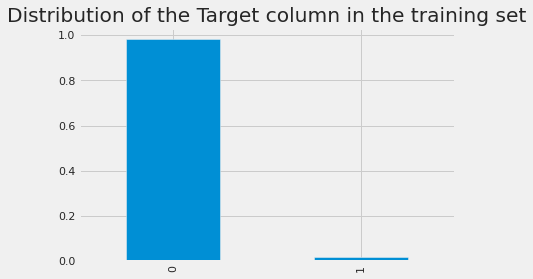

In [11]:
train_df['target'].value_counts(normalize=True).plot(kind='bar', title='Distribution of the Target column in the training set')

## Gender wise distribution


In [12]:
train_df['sex'].value_counts(normalize=True)

male      0.516621
female    0.483379
Name: sex, dtype: float64

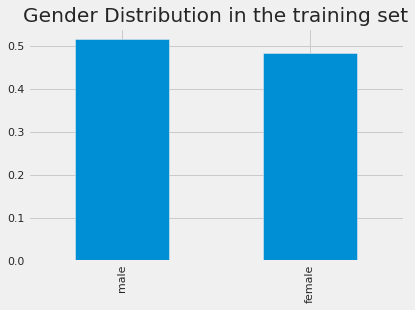

In [13]:
train_df['sex'].value_counts(normalize=True).plot(kind='bar',  title='Gender Distribution in the training set')

## Gender vs Target

In [14]:
z=train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
z.style.background_gradient(cmap='Reds')  

,target,sex,benign_malignant
0,0,female,15761
1,0,male,16716
2,1,female,220
3,1,male,364


Text(0.5, 33.120000000000005, 'benign:0 vs malignant:1')

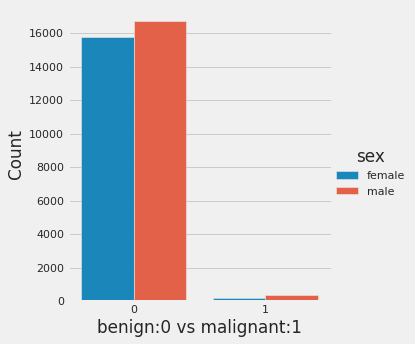

In [15]:
sns.catplot(x='target',y='benign_malignant', hue='sex',data=z,kind='bar')
plt.ylabel('Count')
plt.xlabel('benign:0 vs malignant:1')

## Location of imaged site

In [16]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values()

oral/genital       0.003804
palms/soles        0.011503
head/neck          0.056904
upper extremity    0.152857
lower extremity    0.258198
torso              0.516734
Name: anatom_site_general_challenge, dtype: float64

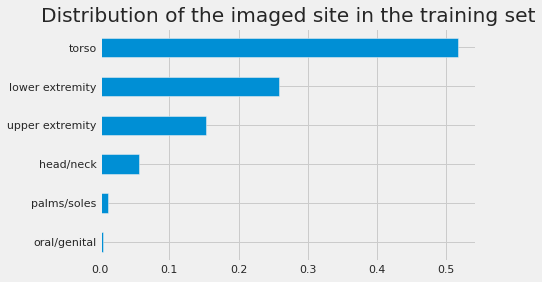

In [17]:
train_df['anatom_site_general_challenge'].value_counts(normalize=True).sort_values().plot(kind='barh',
                                                      title='Distribution of the imaged site in the training set')

## Location of imaged site w.r.t gender

Text(48.30606002604168, 0.5, 'count of melanoma cases')

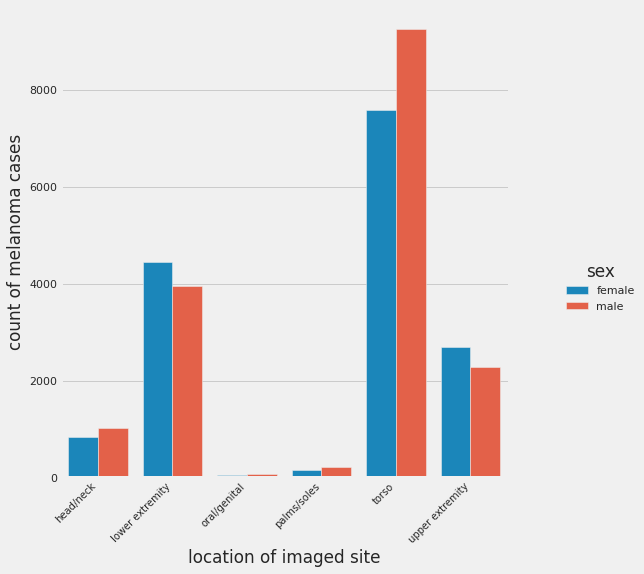

In [18]:

z1=train_df.groupby(['sex','anatom_site_general_challenge'])['benign_malignant'].count().to_frame().reset_index()
z1.style.background_gradient(cmap='Reds')
sns.catplot(x='anatom_site_general_challenge',y='benign_malignant', hue='sex',data=z1,kind='bar')
plt.gcf().set_size_inches(10,8)
plt.xlabel('location of imaged site')
plt.xticks(rotation=45,fontsize='10', horizontalalignment='right')
plt.ylabel('count of melanoma cases')

## Age Distribution of patients

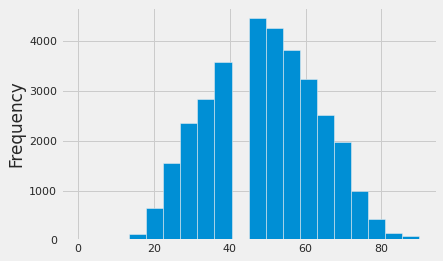

In [19]:
train_df['age_approx'].plot(kind='hist',bins=20)

## Visualising Age KDEs

### Distribution of Ages w.r.t Target

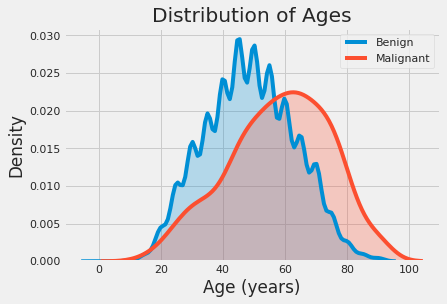

In [20]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(train_df.loc[train_df['target'] == 0, 'age_approx'], label = 'Benign',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['target'] == 1, 'age_approx'], label = 'Malignant',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


### Distribution of Ages w.r.t gender

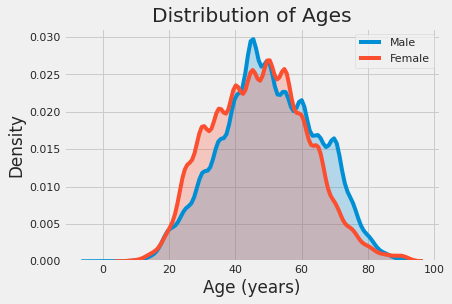

In [21]:
# KDE plot of age that were diagnosed as benign
sns.kdeplot(train_df.loc[train_df['sex'] == 'male', 'age_approx'], label = 'Male',shade=True)

# KDE plot of age that were diagnosed as malignant
sns.kdeplot(train_df.loc[train_df['sex'] == 'female', 'age_approx'], label = 'Female',shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');


## Distribution of Diagnosis

In [22]:
train_df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

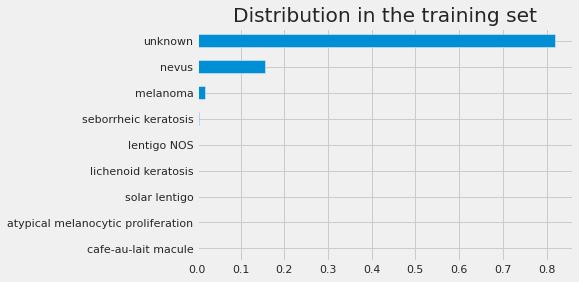

In [23]:
train_df['diagnosis'].value_counts(normalize=True).sort_values().plot(kind='barh',
                                                      title='Distribution in the training set')

## Patient Overlap 
We need to check that the the same patient lesion images shouldn't appear in both training and test set.

In [24]:
# Extract patient id's for the training set
ids_train = train_df.patient_id.values
# Extract patient id's for the validation set
ids_test = test_df.patient_id.values

# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(f'There are {len(ids_train_set)} unique Patient IDs in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(f'There are {len(ids_test_set)} unique Patient IDs in the test set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(f'There are {n_overlap} Patient IDs in both the training and test sets')
print('')
print(f'These patients are in both the training and test datasets:')
print(f'{patient_overlap}')

There are 2056 unique Patient IDs in the training set
There are 690 unique Patient IDs in the test set
There are 0 Patient IDs in both the training and test sets

These patients are in both the training and test datasets:
[]


# 4. Visualising Images : JPEG

## Visualizing a random selection of images

Display Random Images


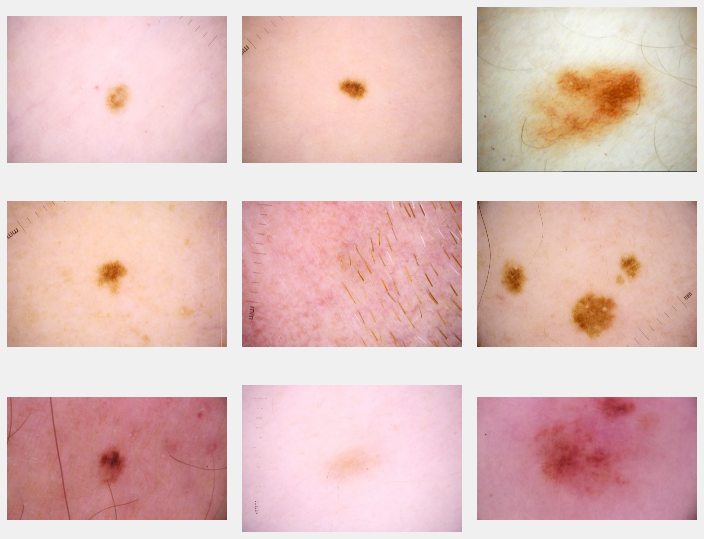

In [25]:
images = train_df['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

We do see that the JPEG format images vary in sizes

## Visualizing Images with benign lesions

In [26]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

Display benign Images


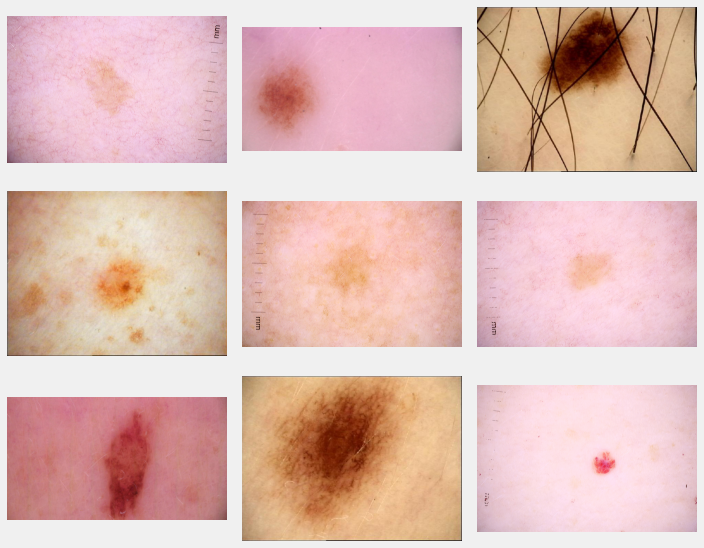

In [27]:
images = benign['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display benign Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

## Visualizing Images with Malignant lesions

Display malignant Images


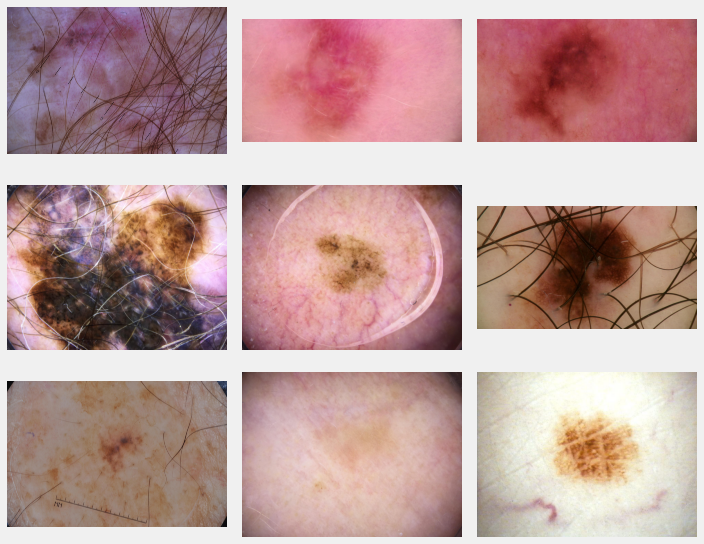

In [28]:
images = malignant['image_name'].values

# Extract 9 random images from it
random_images = [np.random.choice(images+'.jpg') for i in range(9)]

# Location of the image dir
img_dir = IMAGE_PATH+'/jpeg/train'

print('Display malignant Images')

# Adjust the size of your images
plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()   

## Histograms

Histograms are a graphical representation showing how frequently various color values occur in the image i.e frequency of pixels intensity values. In a RGB color space, pixel values range from 0 to 255 where 0 stands for black and 255 stands for white. Analysis of a histogram can help us understand thee brightness, contrast and intensity distribution of an image. Now let's look at the histogram of a random selected sample from each category.

### Benign category

Image dimensions:  (4000, 6000)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 169.9 ; Standard deviation : 41.3


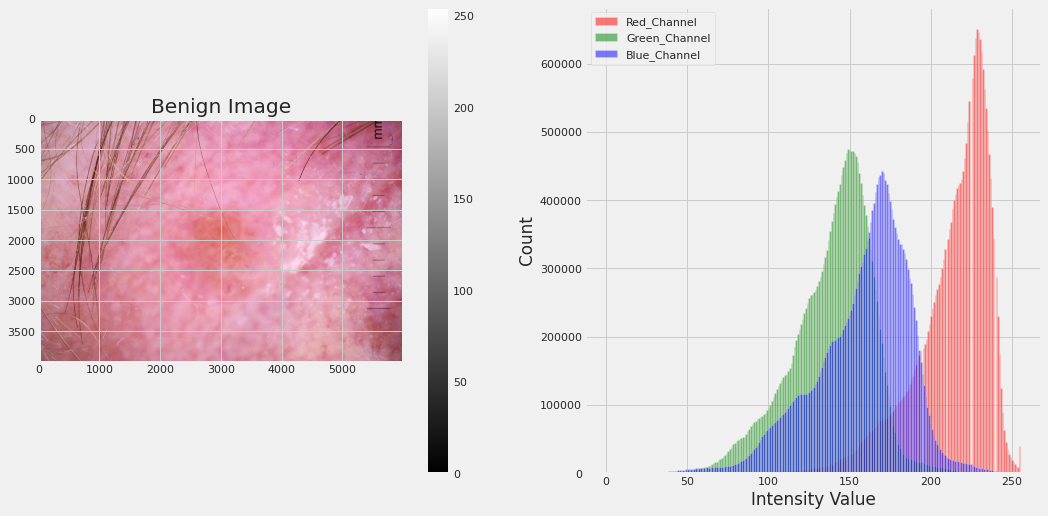

In [29]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = benign['image_name'][0]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

### Malignant category

Image dimensions:  (2448, 3264)
Maximum pixel value : 255.0 ; Minimum pixel value:0.0
Mean value of the pixels : 161.0 ; Standard deviation : 45.1


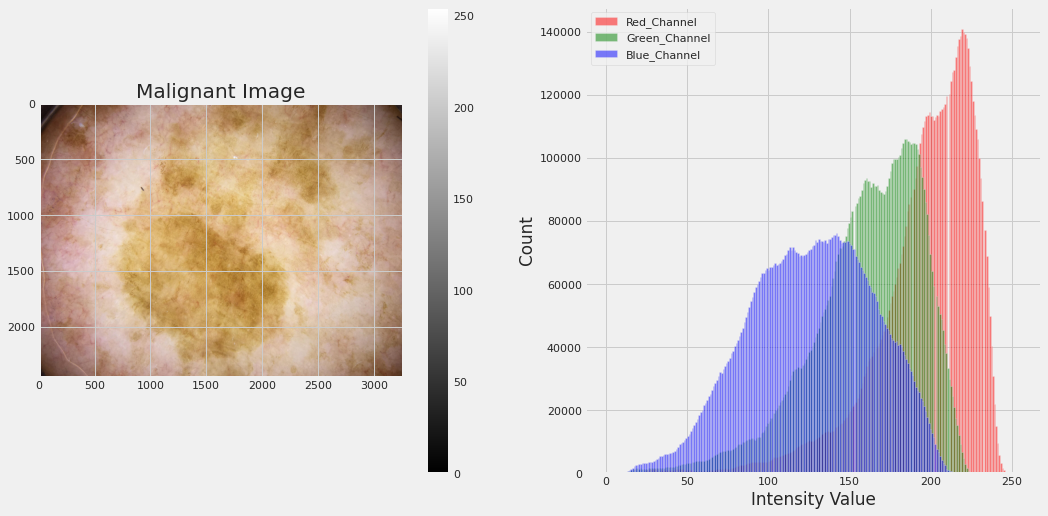

In [30]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)

sample_img = malignant['image_name'][235]+'.jpg'
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# 5 Preprocessing DICOM files 
[Digital Imaging and Communications in Medicine (DICOM)](https://en.wikipedia.org/wiki/DICOM) is the standard for the communication and management of medical imaging information and related data.DICOM is most commonly used for storing and transmitting medical images enabling the integration of medical imaging devices such as scanners, servers, workstations, printers, network hardware, and picture archiving and communication systems (PACS) from multiple manufacturers

DICOM images have the extension dcm. A DICOM file has two parts: the header and the dataset. The header contains information on the encapsulated dataset. It consists of a File Preamble, a DICOM prefix, and the File Meta Elements.
Fortunately we have a library in Python called Pydicom which can be used to read the DIOCOM files.pydicom makes it easy to read these complex files into natural pythonic structures for easy manipulation. Modified datasets can be written again to DICOM format files.

There is very nice [kernel](https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data) from a competition couple of years ago which serves as a great introduction to DICOM image files.I have borrowed the below mentioned code from there.
Kernel: https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data


In [31]:
print (pydicom.__version__)

1.4.2


In [32]:
# https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
   
    
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

Filename.........: ../input/siim-isic-melanoma-classification/train/ISIC_2370610.dcm
Storage type.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Patient's name......: "ISIC, 2370610"
Patient id..........: "ISIC_2370610"
Patient's Age.......: 045Y
Patient's Sex.......: F
Modality............: "XC"
Body Part Examined..: TORSO
Image size.......: 4000 x 6000, 1469034 bytes


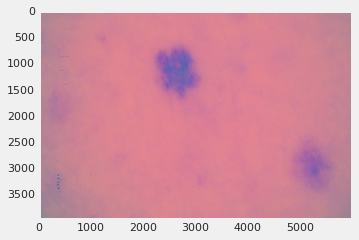

Filename.........: ../input/siim-isic-melanoma-classification/train/ISIC_2080947.dcm
Storage type.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Patient's name......: "ISIC, 2080947"
Patient id..........: "ISIC_2080947"
Patient's Age.......: 030Y
Patient's Sex.......: F
Modality............: "XC"
Body Part Examined..: UPPER EXTREMITY
Image size.......: 1053 x 1872, 1257674 bytes


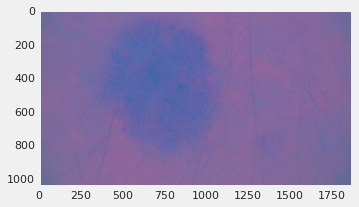

Filename.........: ../input/siim-isic-melanoma-classification/train/ISIC_1194836.dcm
Storage type.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Patient's name......: "ISIC, 1194836"
Patient id..........: "ISIC_1194836"
Patient's Age.......: 030Y
Patient's Sex.......: F
Modality............: "XC"
Body Part Examined..: UPPER EXTREMITY
Image size.......: 4000 x 6000, 1596498 bytes


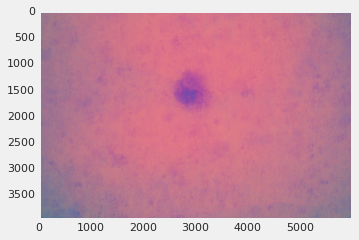

Filename.........: ../input/siim-isic-melanoma-classification/train/ISIC_2162118.dcm
Storage type.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Patient's name......: "ISIC, 2162118"
Patient id..........: "ISIC_2162118"
Patient's Age.......: 030Y
Patient's Sex.......: M
Modality............: "XC"
Body Part Examined..: TORSO
Image size.......: 4000 x 6000, 1152880 bytes


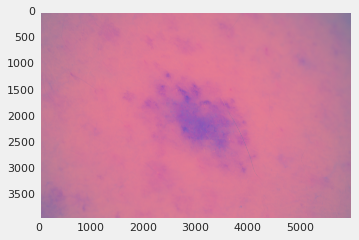

Filename.........: ../input/siim-isic-melanoma-classification/train/ISIC_1043313.dcm
Storage type.....: "1.2.840.10008.5.1.4.1.1.77.1.4"

Patient's name......: "ISIC, 1043313"
Patient id..........: "ISIC_1043313"
Patient's Age.......: 060Y
Patient's Sex.......: M
Modality............: "XC"
Body Part Examined..: HEAD/NECK
Image size.......: 3024 x 4032, 4348006 bytes


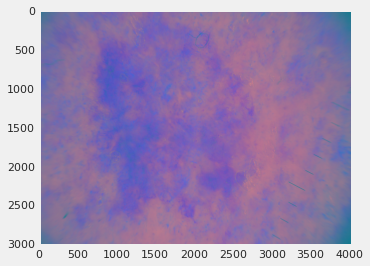

In [33]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array)
    plt.show()
    
i = 1
num_to_plot = 5
for file_name in os.listdir('../input/siim-isic-melanoma-classification/train/'):
        file_path = os.path.join('../input/siim-isic-melanoma-classification/train/',file_name)
        dataset = pydicom.dcmread(file_path)
        show_dcm_info(dataset)
        plot_pixel_array(dataset)
    
        if i >= num_to_plot:
            break
    
        i += 1

## Extracting DICOM files information in a dataframe

[Gabriel Preda](https://www.kaggle.com/gpreda) has shared the following code in the [discussion forum](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/154658) which let's you easily extract the relevant information from the diocom files and store it in a dataframe.

In [34]:
# source: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/154658
folder='train'
PATH='../input/siim-isic-melanoma-classification/'

def extract_DICOM_attributes(folder):
    images = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    for image in images:
        image_name = image.split(".")[0]
        dicom_file_path = os.path.join(PATH,folder,image)
        dicom_file_dataset = pydicom.read_file(dicom_file_path)
        study_date = dicom_file_dataset.StudyDate
        modality = dicom_file_dataset.Modality
        age = dicom_file_dataset.PatientAge
        sex = dicom_file_dataset.PatientSex
        body_part_examined = dicom_file_dataset.BodyPartExamined
        patient_orientation = dicom_file_dataset.PatientOrientation
        photometric_interpretation = dicom_file_dataset.PhotometricInterpretation
        rows = dicom_file_dataset.Rows
        columns = dicom_file_dataset.Columns

        df = df.append(pd.DataFrame({'image_name': image_name, 
                        'dcm_modality': modality,'dcm_study_date':study_date, 'dcm_age': age, 'dcm_sex': sex,
                        'dcm_body_part_examined': body_part_examined,'dcm_patient_orientation': patient_orientation,
                        'dcm_photometric_interpretation': photometric_interpretation,
                        'dcm_rows': rows, 'dcm_columns': columns}, index=[0]))
    return df

In [35]:
extract_DICOM_attributes('train')

,image_name,dcm_modality,dcm_study_date,dcm_age,dcm_sex,dcm_body_part_examined,dcm_patient_orientation,dcm_photometric_interpretation,dcm_rows,dcm_columns
0,ISIC_2370610,"""XC""",20200519,045Y,F,TORSO,,YBR_FULL_422,4000,6000
0,ISIC_2080947,"""XC""",20200519,030Y,F,UPPER EXTREMITY,,YBR_FULL_422,1053,1872
0,ISIC_1194836,"""XC""",20200520,030Y,F,UPPER EXTREMITY,,YBR_FULL_422,4000,6000
0,ISIC_2162118,"""XC""",20200520,030Y,M,TORSO,,YBR_FULL_422,4000,6000
0,ISIC_1043313,"""XC""",20200519,060Y,M,HEAD/NECK,,YBR_FULL_422,3024,4032
...,...,...,...,...,...,...,...,...,...,...
0,ISIC_9218360,"""XC""",20200519,025Y,M,LOWER EXTREMITY,,YBR_FULL_422,5184,3456
0,ISIC_0672985,"""XC""",20200519,070Y,M,TORSO,,YBR_FULL_422,1053,1872
0,ISIC_2636672,"""XC""",20200520,020Y,F,TORSO,,YBR_FULL_422,4000,6000
0,ISIC_1843497,"""XC""",20200520,050Y,F,LOWER EXTREMITY,,YBR_FULL_422,4000,6000
